<a href="https://colab.research.google.com/github/hyunjaec/MScA_Machine_Learning_Project/blob/main/medical_deepfakes_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import pydicom
import scipy.ndimage

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = np.float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [4]:
! ls 'drive/My Drive/data_ml'

'Experiment 2 - Open'
 labels_exp2.csv
'Response EXP2 - Reviewer 1_instances.csv'
'Response EXP2 - Reviewer 1_patients.csv'
'Response EXP2 - Reviewer 2_instances.csv'
'Response EXP2 - Reviewer 2_patients.csv'
'Response EXP2 - Reviewer 3_instances.csv'
'Response EXP2 - Reviewer 3_patients.csv'


In [5]:
scan_uuid = 1251
scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/data_ml/Experiment 2 - Open/'+str(scan_uuid))

print('The CT scan has the dimensions of',scan.shape,'  (z,y,x)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


The CT scan has the dimensions of (330, 512, 512)   (z,y,x)


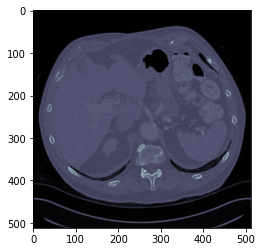

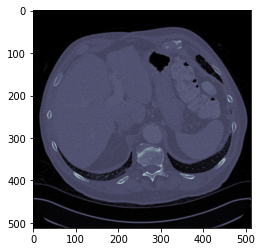

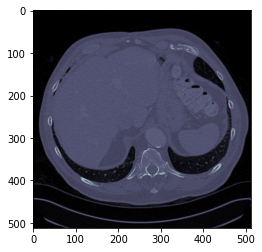

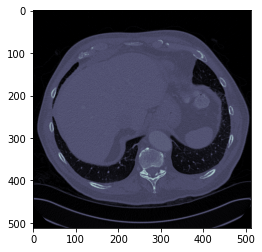

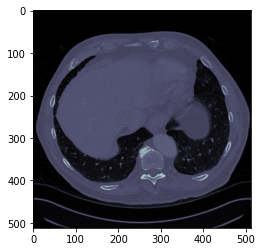

In [6]:
from matplotlib import pyplot as plt

for slice_indx in range(50,100,10):
    plt.imshow(scan[slice_indx,:,:],cmap='bone',vmin=-1000,vmax=2000)
    plt.show()

In [7]:
df = pd.read_csv('/content/drive/My Drive/data_ml/labels_exp2.csv')
locations = df.loc[df['uuid']==scan_uuid]
locations

,type,uuid,slice,x,y
0,FB,1251,150,418,350
1,FB,1251,188,402,294
2,FB,1251,272,163,298


In [8]:
def cutCube(X, center, shape, padd=0): #center is a 3d coord (zyx)
    center = center.astype(int)
    hlz = np.round(shape[0] / 2)
    hly = np.round(shape[1] / 2)
    hlx = np.round(shape[2] / 2)

    #add padding if out of bounds
    if ((center - np.array([hlz,hly,hlx])) < 0).any() or (
        (center + np.array([hlz,hly,hlx]) + 1) > np.array(X.shape)).any():  # if cropping is out of bounds, add padding
        try:
          np.ones(np.array(X.shape) + shape * 2)
        except:
          return "No"
        Xn = np.ones(np.array(X.shape) + shape * 2) * padd
        Xn[shape[0]:(shape[0] + X.shape[0]), shape[1]:(shape[1] + X.shape[1]), shape[2]:(shape[2] + X.shape[2])] = X
        centern = center + shape
        cube = Xn[int(centern[0] - hlz):int(centern[0] - hlz + shape[0]),
               int(centern[1] - hly):int(centern[1] - hly + shape[1]),
               int(centern[2] - hlx):int(centern[2] - hlx + shape[2])]
        return np.copy(cube)
    else:
        cube = X[int(center[0] - hlz):int(center[0] - hlz + shape[0]), int(center[1] - hly):int(center[1] - hly + shape[1]),
               int(center[2] - hlx):int(center[2] - hlx + shape[2])]
        return np.copy(cube)


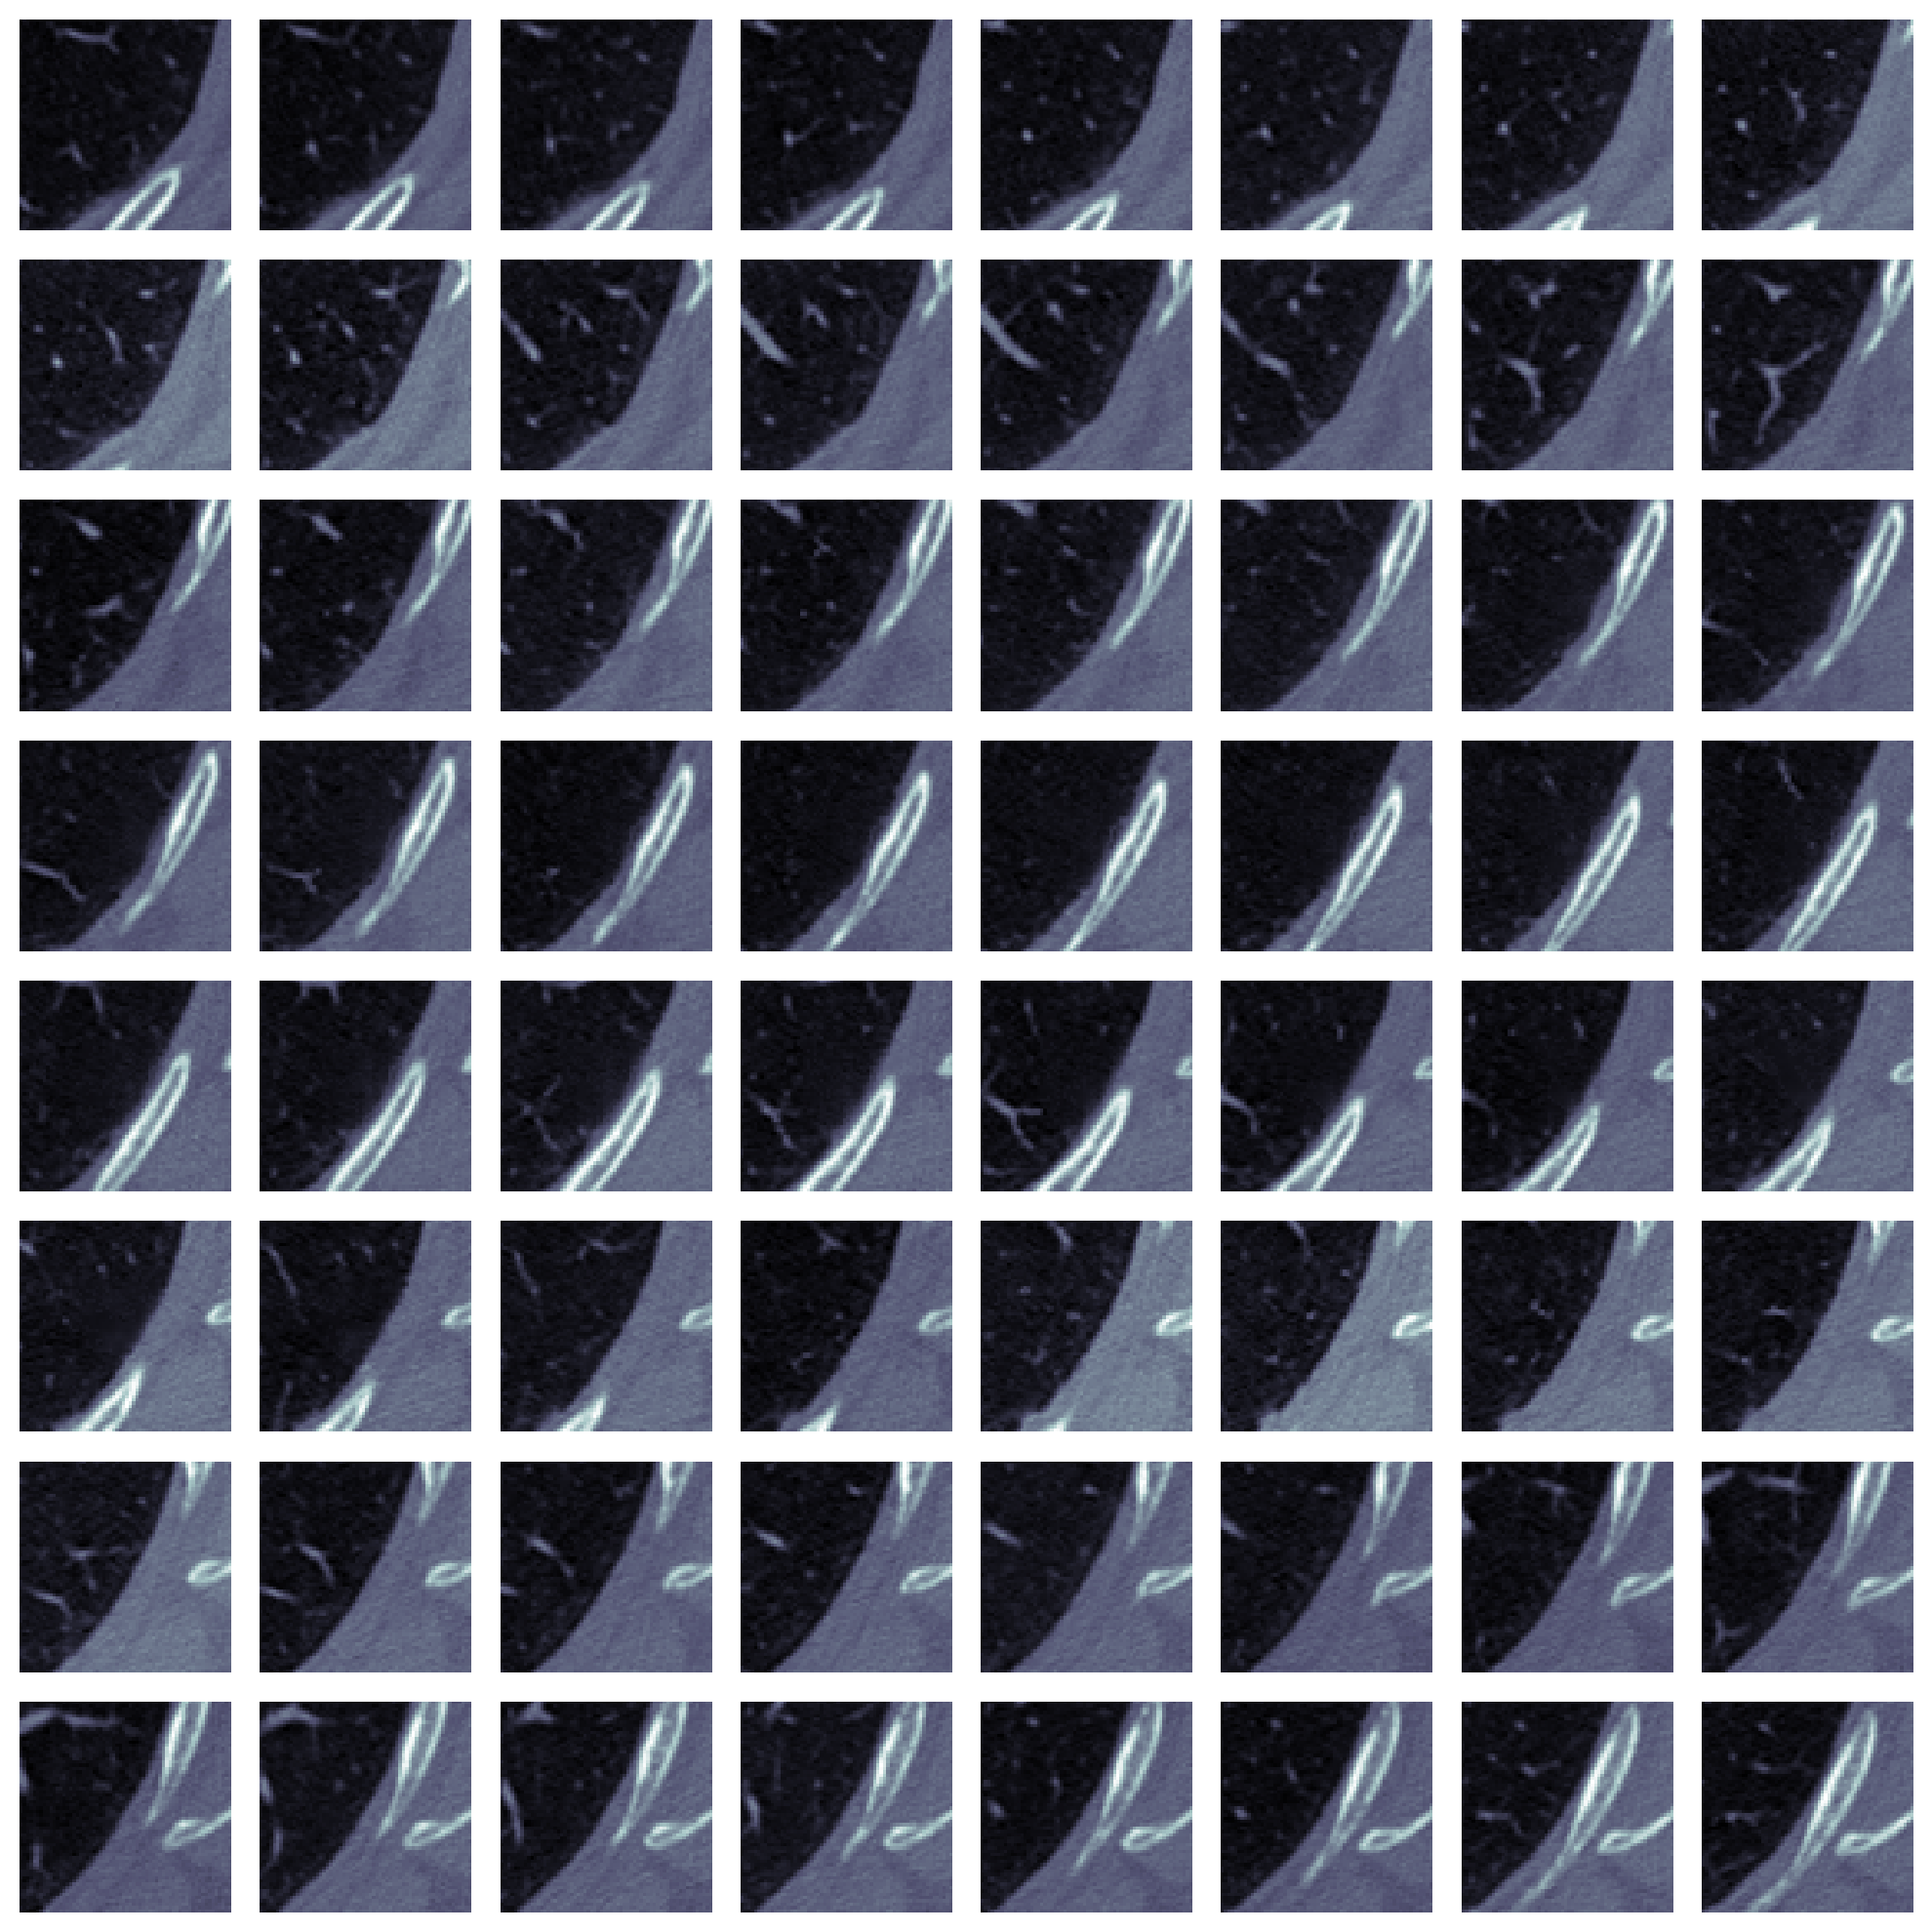

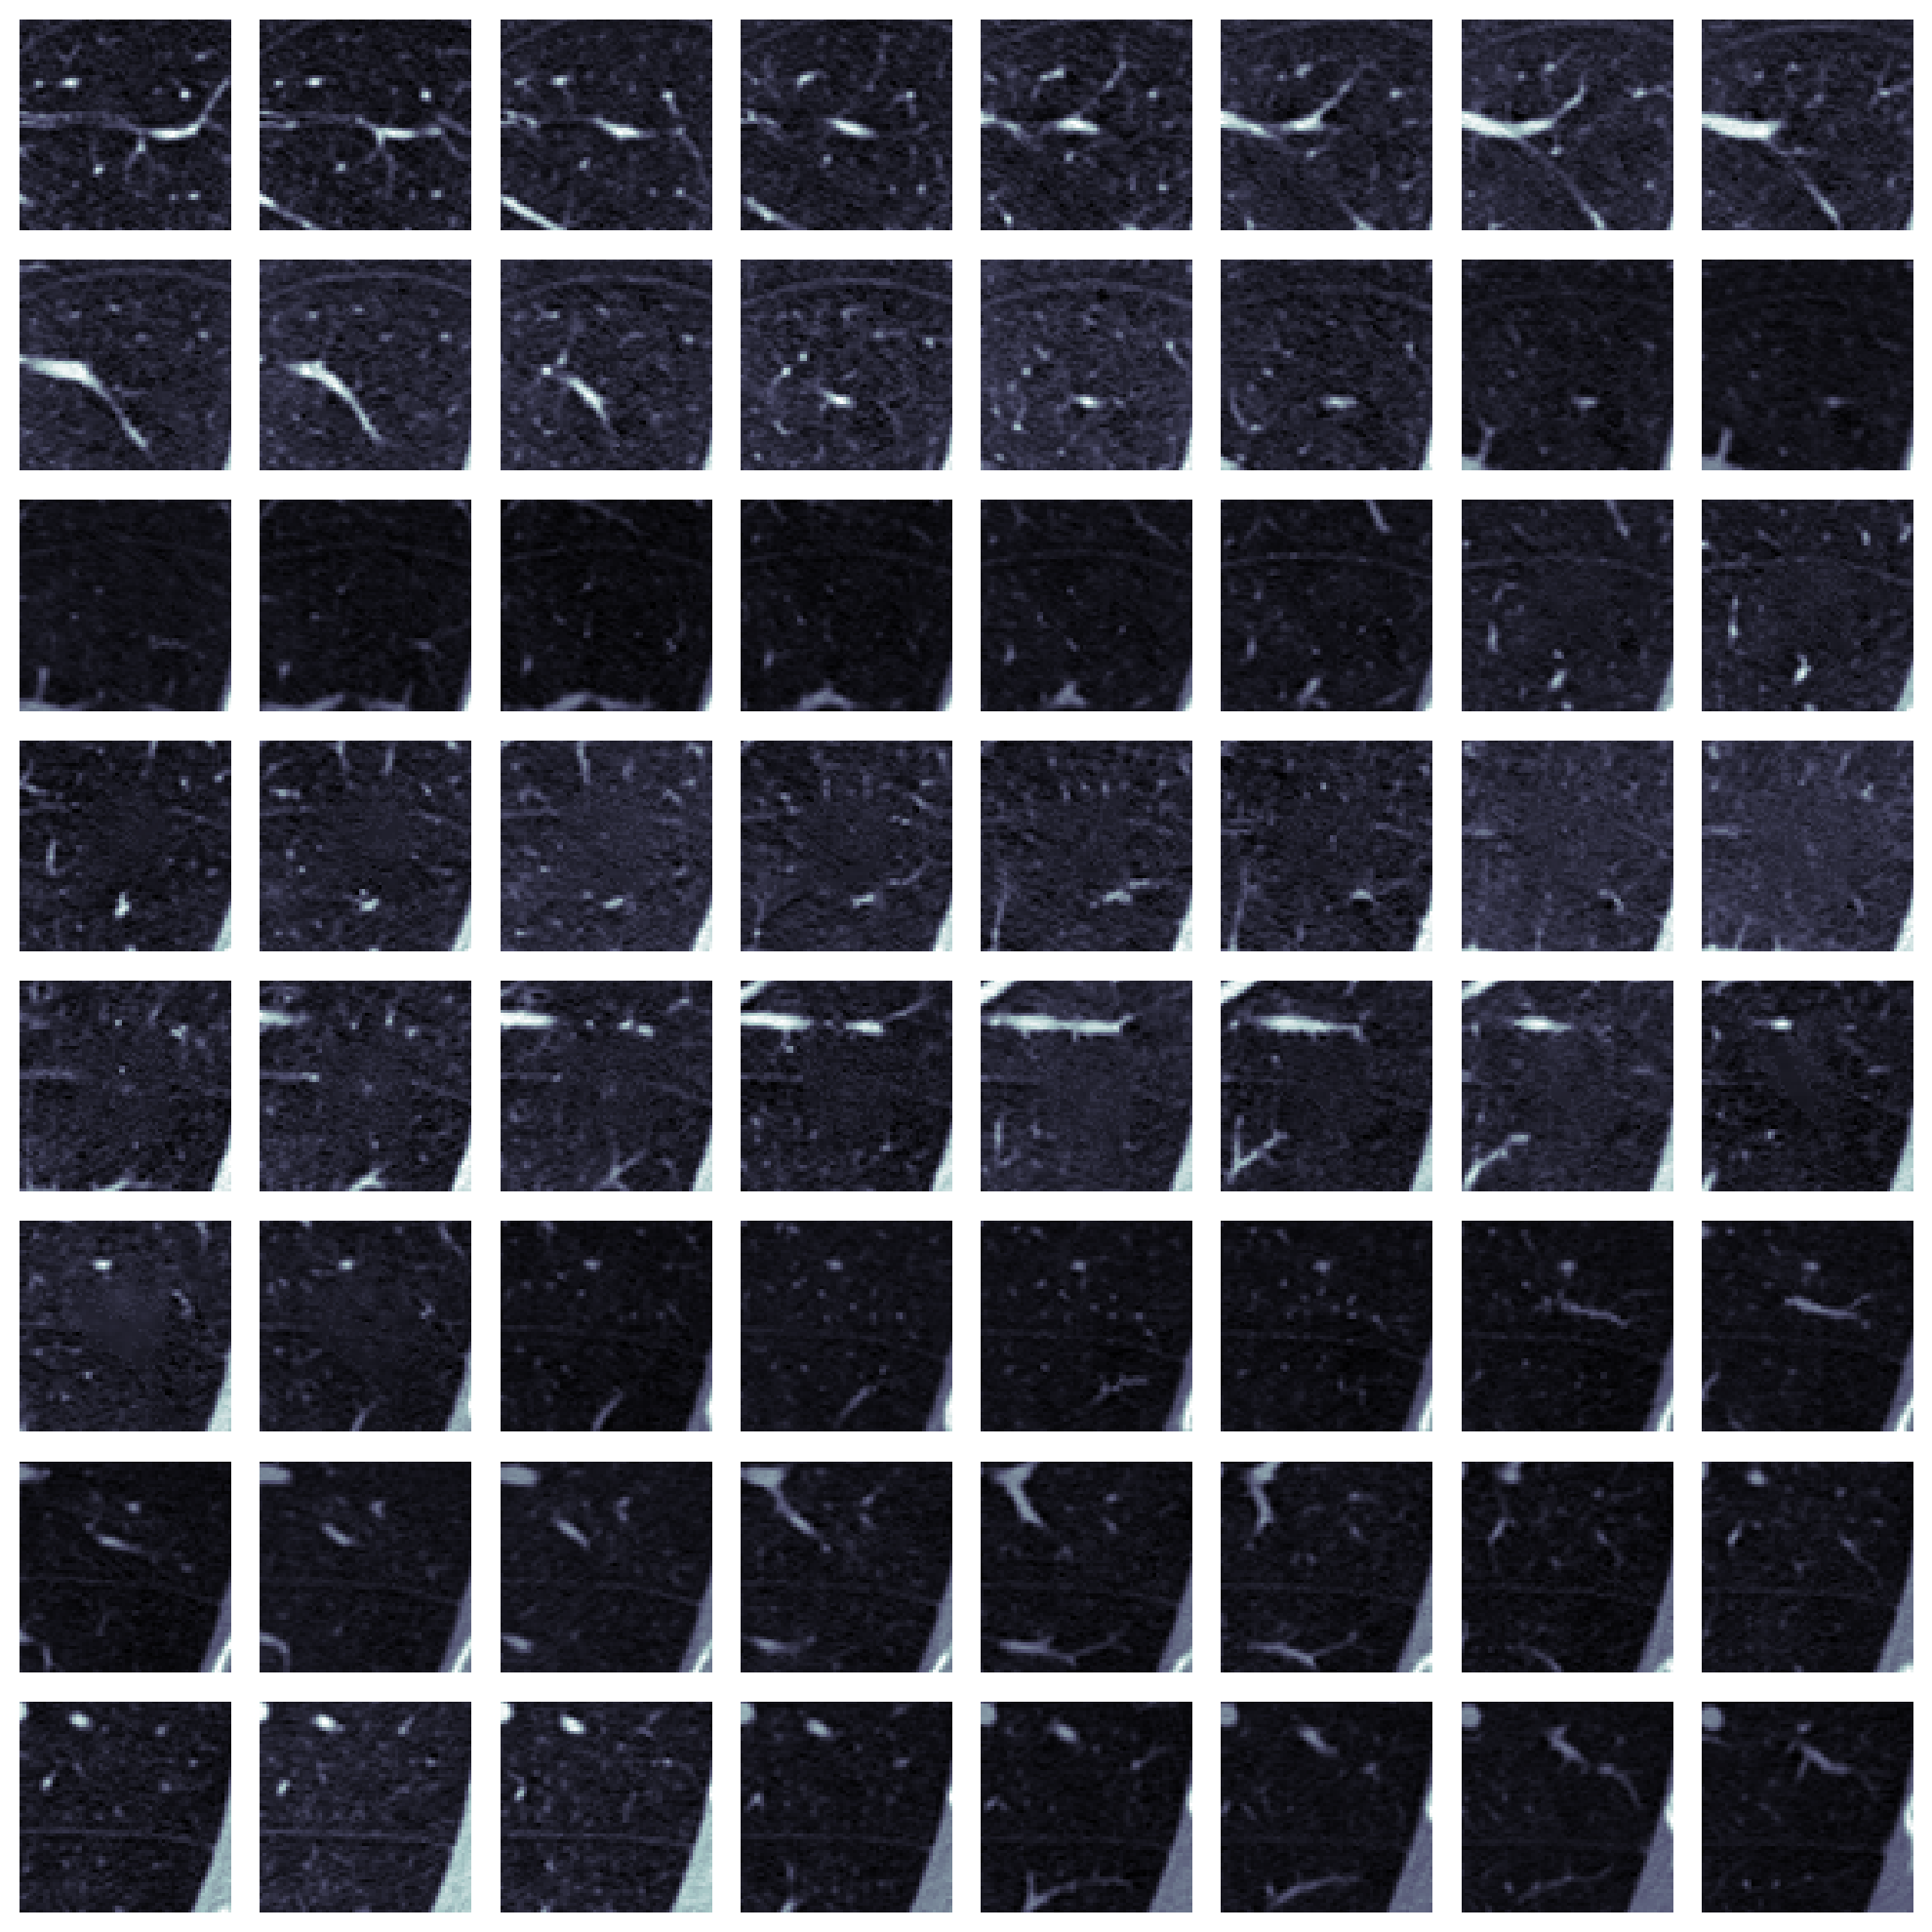

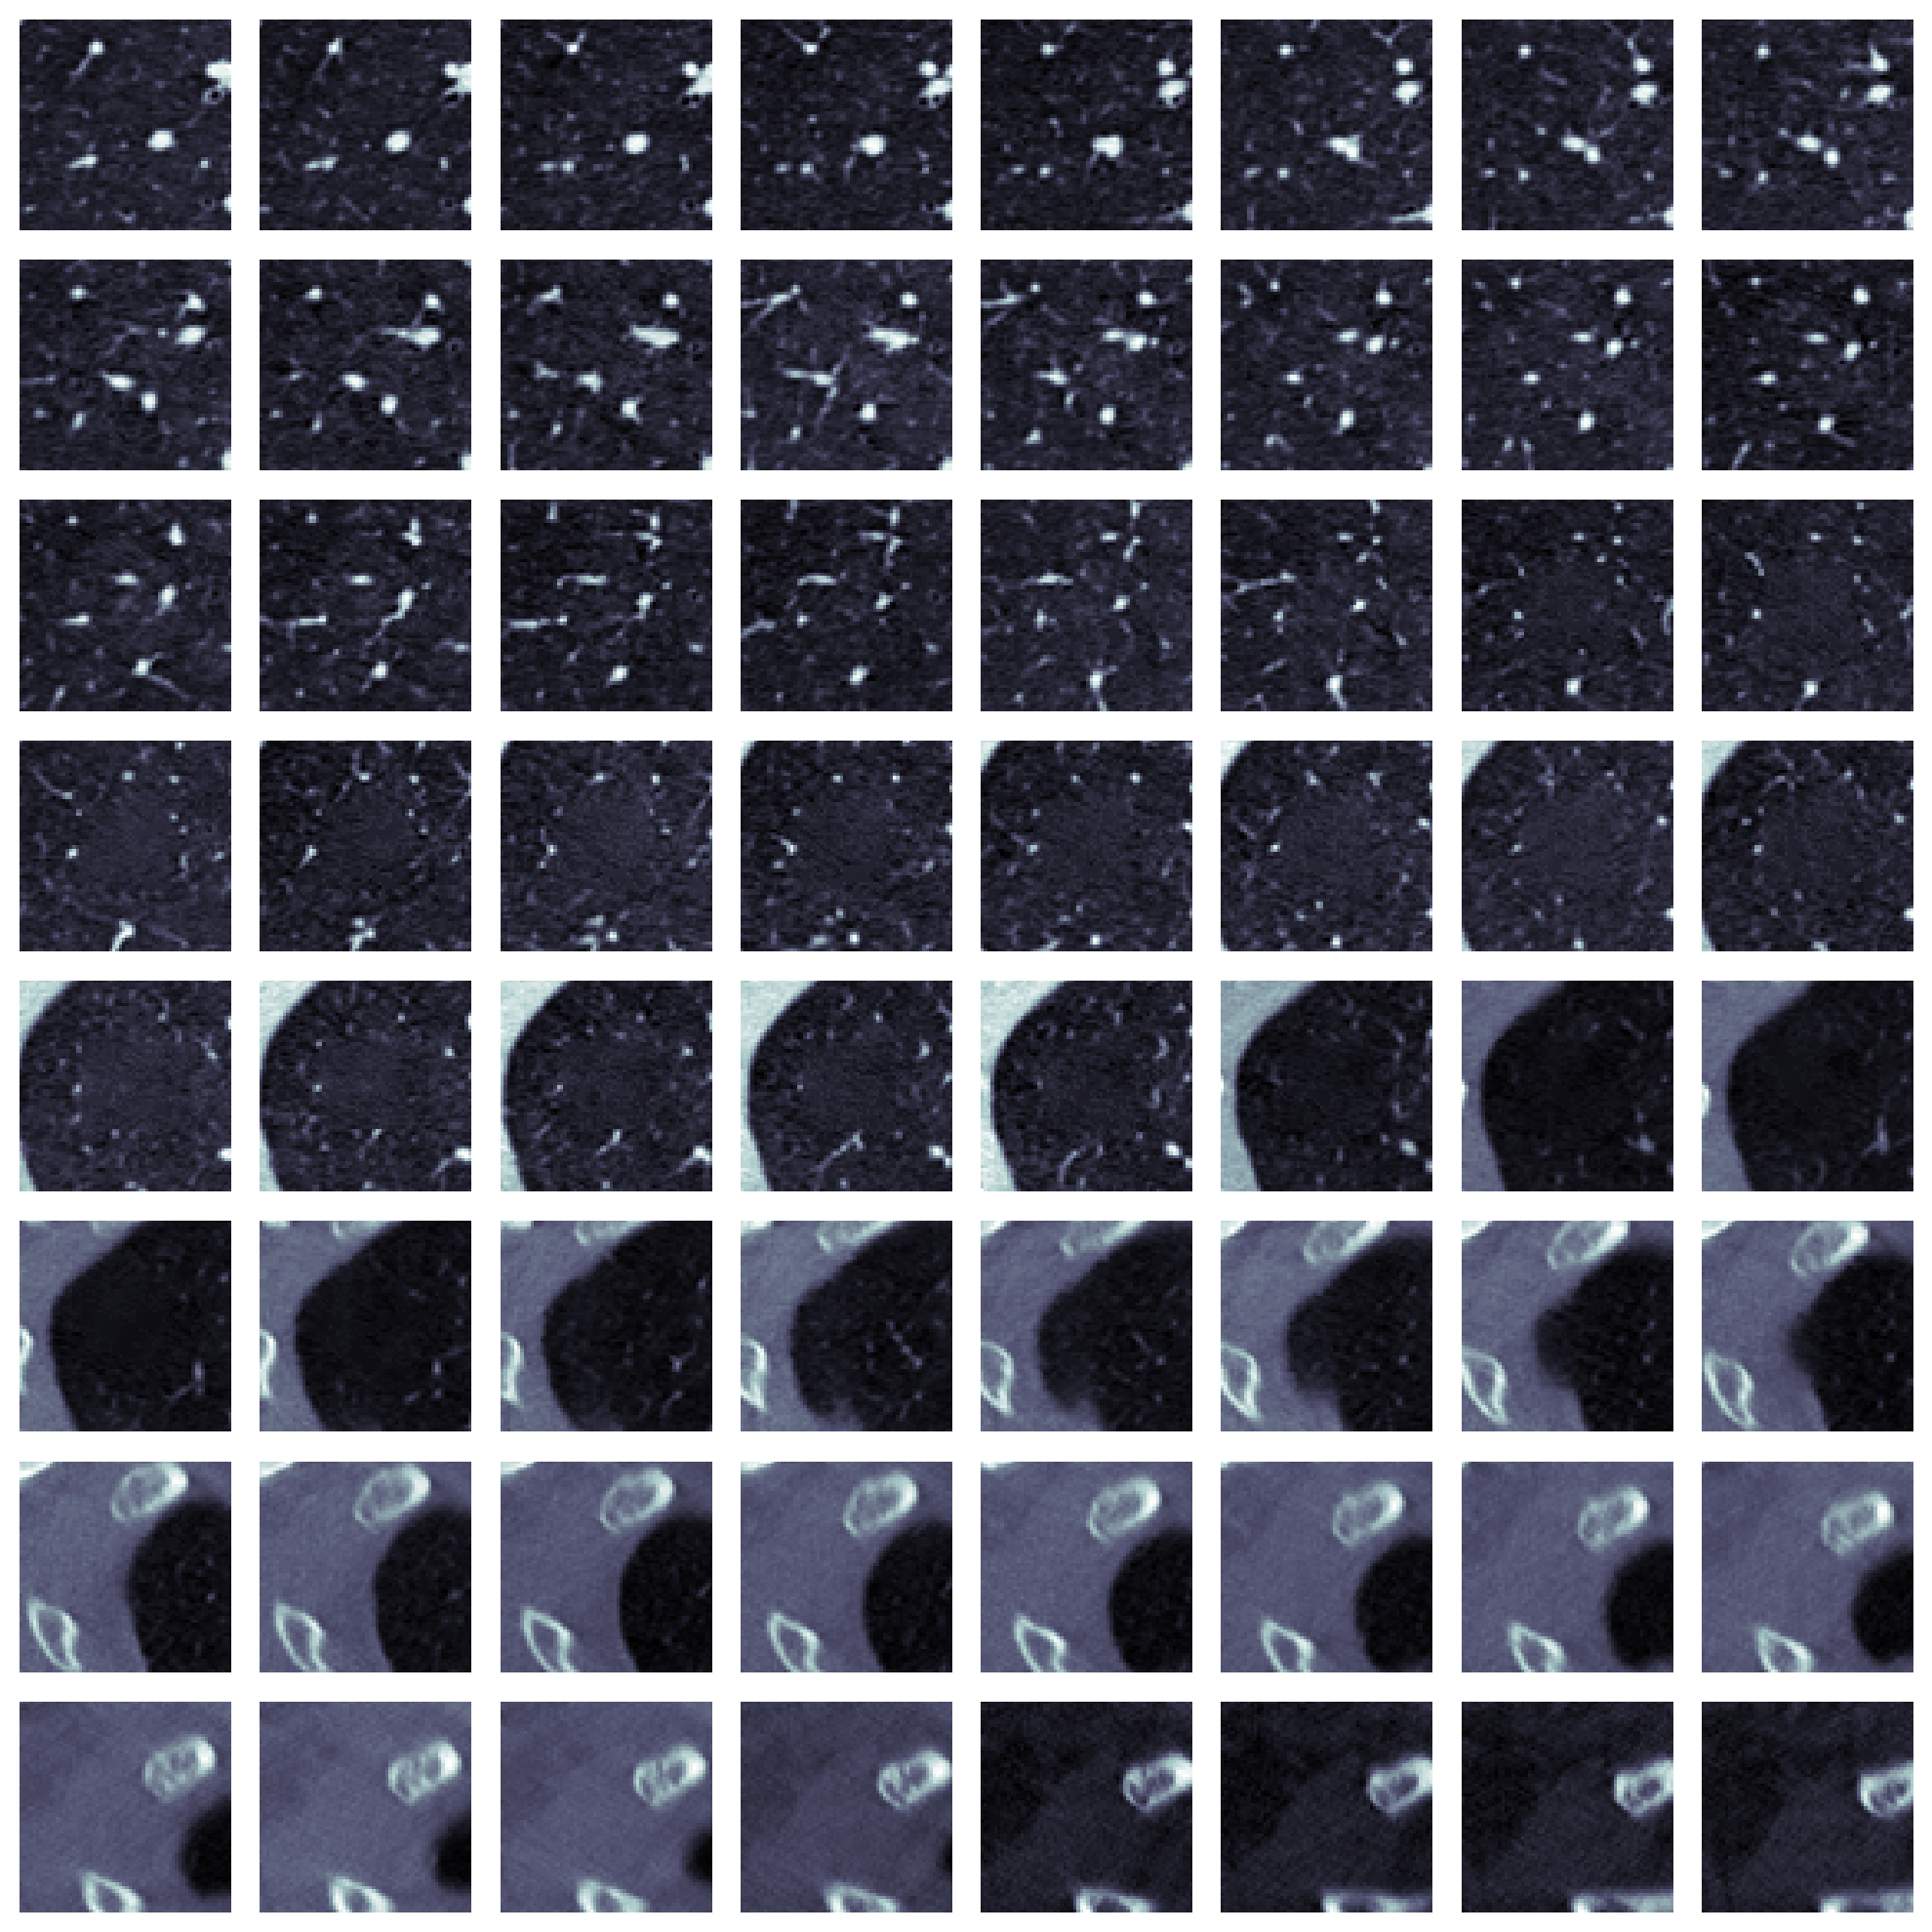

In [9]:
cut_cubes = []
for i in range(len(locations)):
    location = locations.iloc[i]
    coord = np.array([location['slice'],location['y'],location['x']])
    cut_cubes.append(cutCube(scan,coord,(64,64,64)))

#disply the slices of each cut cube:
for cube in cut_cubes:
    plt.figure(num=None, figsize=(10, 10), dpi=200)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(cube[i,:,:],cmap='bone')
    plt.show()

In [10]:
import os
dir = "/content/drive/My Drive/Data/data_ml/Experiment 2 - Open/"
r=[]
for root, dirs, files in os.walk(dir):
  r.append(root)

In [11]:
label_df = pd.read_csv('/content/drive/My Drive/data_ml/Response EXP2 - Reviewer 1_instances.csv')
df_true = label_df.loc[label_df['label']==True]
df_false = label_df.loc[label_df['label']==False]

In [12]:
df_true.uuid[0]

1251

In [13]:
df_true = df_true.reset_index()
df_false = df_false.reset_index()

In [14]:
def image_cut_processing(df):
  cut_cubes = []
  for i in range(0,len(df)):
    scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/data_ml/Experiment 2 - Open/'+str(df.uuid[i]))
    uuid_row = df.loc[df['uuid'] == df.uuid[i]]
    for j in range(len(uuid_row)):
      location = uuid_row.iloc[j]
      coord = np.array([location['slice'],location['y'],location['x']])
      if (cutCube(scan,coord,(64,64,64))) != "No":
        cut_cubes.append(cutCube(scan,coord,(64,64,64)))
  return cut_cubes
  

In [15]:
true_cut_images = image_cut_processing(df_true)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [16]:
false_cut_images = image_cut_processing(df_false)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [17]:
list1 = [True for i in range(len(true_cut_images))]
list2 = [False for i in range(len(false_cut_images))]
y = list1+list2
y = np.array(y)

In [18]:
y = pd.get_dummies(y)

In [19]:
X = true_cut_images + false_cut_images

In [20]:
len(X), len(y)

(72, 72)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [22]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [23]:
len(y_train)

57

In [24]:
X_test[8].shape

(64, 64, 64)

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv3D, MaxPooling3D
from keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [26]:
input_shape = (64,64,64,1)
model = Sequential()
model.add(Conv3D(32, kernel_size=(3,3,3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv3D(64, (3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [27]:
model.compile(optimizer = tf.keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 62, 62, 62, 32)    896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 62, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 60, 60, 60, 64)    55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 30, 30, 64)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 30, 64)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 28, 28, 28, 64)    1

In [29]:
batch_size = 5
epochs = 50

In [30]:
history = model.fit(x=X_train, y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 293s 24s/step - loss: 0.7671 - accuracy: 0.7544 - val_loss: 1.6984 - val_accuracy: 0.7333
Epoch 2/50
12/12 [==============================] - 275s 23s/step - loss: 0.7671 - accuracy: 0.8070 - val_loss: 1.4062 - val_accuracy: 0.7333
Epoch 3/50
12/12 [==============================] - 278s 23s/step - loss: 0.4858 - accuracy: 0.8596 - val_loss: 1.0142 - val_accuracy: 0.7333
Epoch 4/50
12/12 [==============================] - 281s 23s/step - loss: 0.5224 - accuracy: 0.8596 - val_loss: 0.8222 - val_accuracy: 0.7333
Epoch 5/50
12/12 [==============================] - 275s 23s/step - loss: 0.5168 - accuracy: 0.8596 - val_loss: 0.6961 - val_accuracy: 0.7333
Epoch 6/50
12/12 [==============================] - 273s 23s/step - loss: 0.3289 - accuracy: 0.8947 - val_loss: 0.7155 - val_accuracy: 0.7333
Epoch 7/50
12/12 [==============================] - 284s 24s/step - loss: 0.2983 - accuracy: 0.8947 - val_loss: 0.5702 - val_accuracy: 0.7333
Epoch 

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [0.2691788077354431, 0.9333333373069763]


Text(0.5, 1.0, 'Loss Curves')

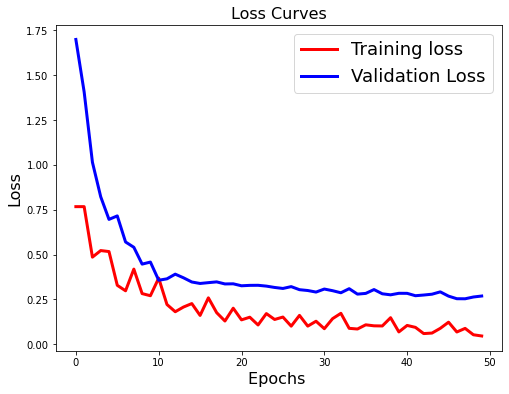

In [32]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

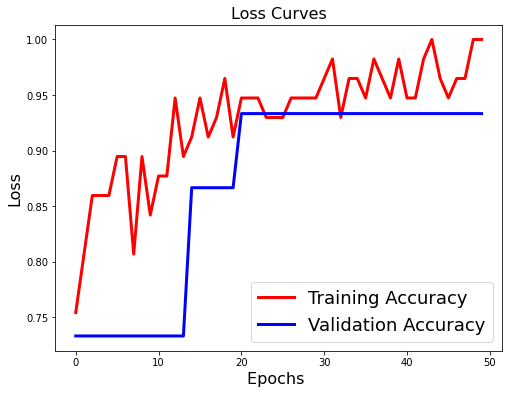

In [35]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [36]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [37]:
y_test_back = pd.Series(pd.DataFrame(y_test, columns = [0, 1]).columns[np.where(y_test!=0)[1]])
np.array(y_test_back)

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_back, y_pred)

In [39]:
cm

array([[ 3,  1],
       [ 0, 11]])

In [40]:
from google.colab.patches import cv2_imshow

In [41]:
cube[i,:,:]

array([[ 50.,  73.,  26., ..., -24., -37., -13.],
       [ 33.,  77.,  20., ...,   8.,   5.,  23.],
       [ 40.,  35.,  55., ...,  44.,  -7.,  21.],
       ...,
       [-28., -23.,  -3., ..., 556., 579., 760.],
       [ 23., -38., -58., ..., 563., 653., 695.],
       [-78., -14.,  51., ..., 655., 714., 751.]])

In [42]:
cube[1].shape

(64, 64)

In [43]:
X_test[1][-2].shape

(64, 64)

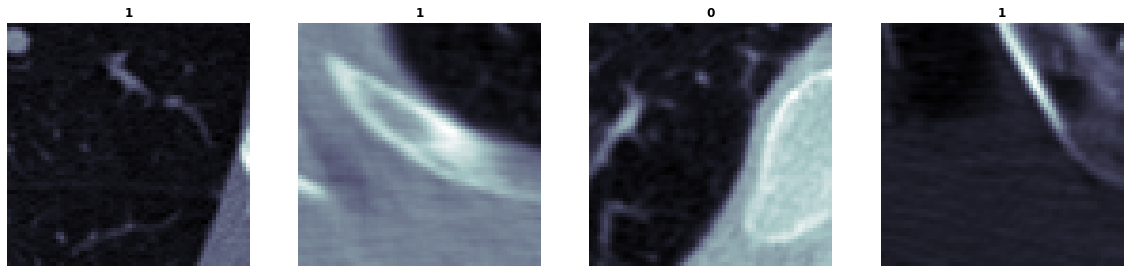

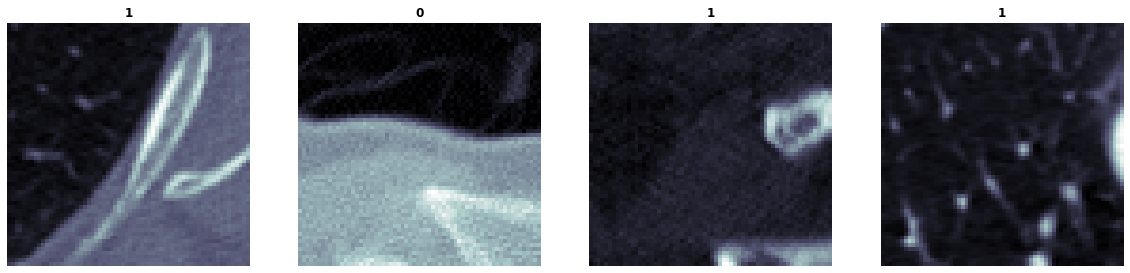

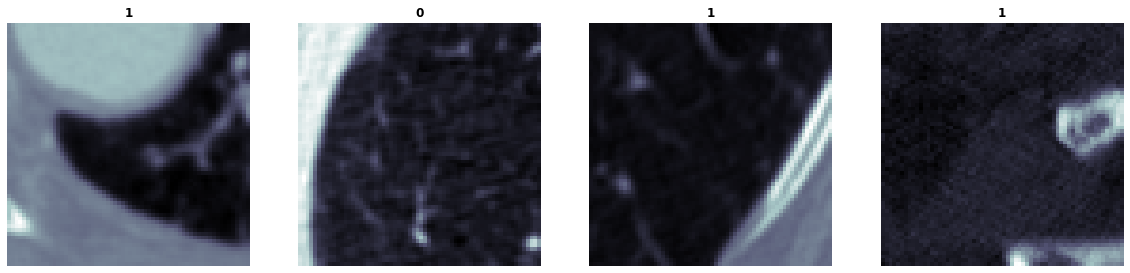

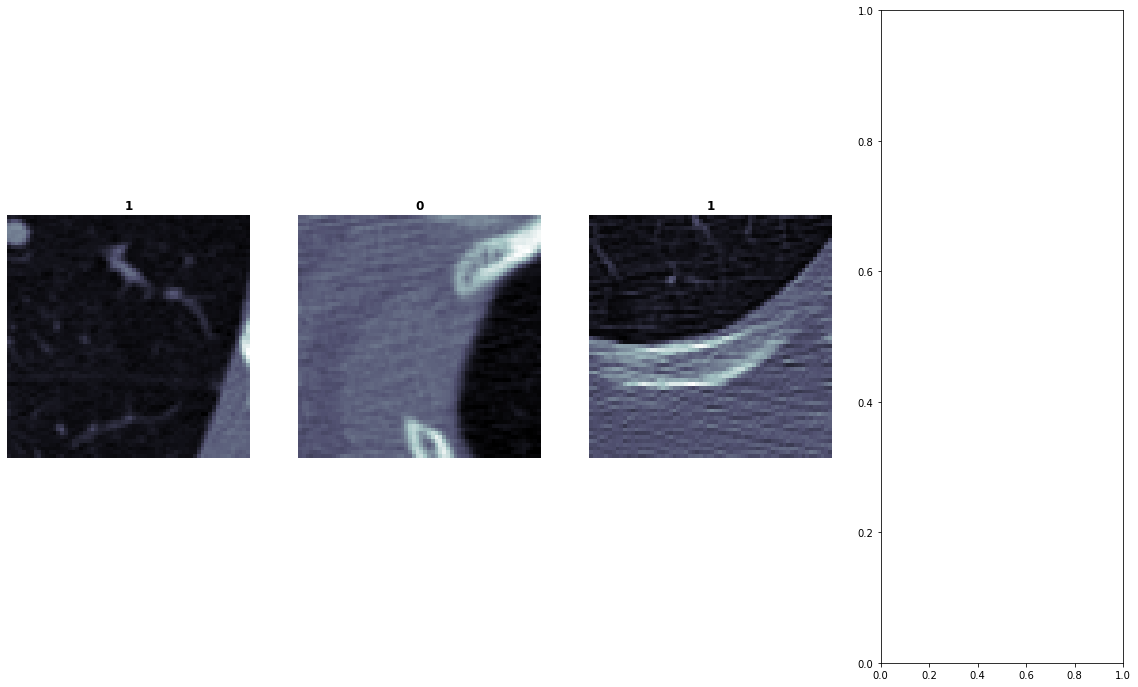

In [44]:
COL_SIZE = 4
for i in range(0,len(X_test),COL_SIZE):
    fig, ax = plt.subplots(nrows=1, ncols=COL_SIZE, figsize=(20, 12))
    for j in range(0,len(ax)):
        if i+j < len(X_test):
            ax[j].imshow(X_test[i+j][-2],cmap='bone')
            ax[j].axis('off')
            ax[j].set_title(y_test_back[i+j], fontsize = 12, fontweight='bold')